### =========================================
### Crypto Risk Thermometer - Unified Notebook
### =========================================

In [9]:
import requests
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import streamlit as st
from dotenv import load_dotenv

#### -----------------------------------------
#### 1. Data Layer - Load or Fetch Data
#### -----------------------------------------

In [13]:
# ==============================
# Loading the Bitcoin Market Cap Data, Total Market Cap and Bitcoin Dominance
# ==============================
load_dotenv()
api_key = os.getenv("GECKO_KEY")

headers = {"accept": "application/json", "x-cg-pro-api-key": api_key}
params = {"vs_currency": "usd", "days": "max"}

# ==============================
# 1. Fetch BTC market cap
# ==============================
btc_url = "https://pro-api.coingecko.com/api/v3/coins/bitcoin/market_chart"
btc_res = requests.get(btc_url, headers=headers, params=params)
btc_res.raise_for_status()
btc_data = btc_res.json()["market_caps"]

df_btc = pd.DataFrame(btc_data, columns=["timestamp", "btc_mcap"])
df_btc["date"] = pd.to_datetime(df_btc["timestamp"], unit="ms")
df_btc = df_btc.set_index("date").drop(columns="timestamp")

# ==============================
# 2. Fetch Global Market Cap
# ==============================
global_url = "https://pro-api.coingecko.com/api/v3/global/market_cap_chart"
global_res = requests.get(global_url, headers=headers, params=params)
global_res.raise_for_status()
global_data = global_res.json()["market_cap_chart"]["market_cap"]

df_global = pd.DataFrame(global_data, columns=["timestamp", "total_mcap"])
df_global["date"] = pd.to_datetime(df_global["timestamp"], unit="ms")
df_global = df_global.set_index("date").drop(columns="timestamp")

# ==============================
# 3. Merge and Compute Dominance
# ==============================
df = pd.concat([df_btc, df_global], axis=1)
df["btc_dominance"] = (df["btc_mcap"] / df["total_mcap"]) * 100

# Resample monthly (end of month)
df_monthly = df.resample("M").last()

#df_btc
#df_global
df_monthly

C:\Users\Muhammad\AppData\Local\Temp\ipykernel_12380\2826377221.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample("M").last()


,btc_mcap,total_mcap,btc_dominance
date,,,
2013-04-30,1.501657e+09,1.592765e+09,94.279912
2013-05-31,1.436387e+09,1.501247e+09,95.679597
2013-06-30,1.082694e+09,1.144211e+09,94.623619
2013-07-31,1.267183e+09,1.339437e+09,94.605666
2013-08-31,1.602407e+09,1.718393e+09,93.250332
...,...,...,...
2025-05-31,2.066831e+12,3.374423e+12,61.249910
2025-06-30,2.155183e+12,3.461180e+12,62.267302
2025-07-31,2.343718e+12,3.931253e+12,59.617574


In [14]:
# Loading the inflation data

load_dotenv() # Get the .env file

FRED_API_KEY = os.getenv('FRED_API') # Fetching the FRED API key from environment variables

fred_url = 'https://api.stlouisfed.org/fred/series/observations' # Fred API endpoint we will be using


# Specify the params for the Api Endpoint
params = {
    'api_key': FRED_API_KEY,
    'file_type': 'json',
    'series_id': 'CPIAUCSL',
    'observation_start': '1975-01-01',
    'units': 'ch1',
    'frequency': 'm'
}

response = requests.get(url=fred_url, params=params) # url + specified params
response.raise_for_status()
data = response.json() # Parse the JSON

observations = data['observations'] # Separate the data

df_cpi = pd.DataFrame(observations)[['date', 'value']] # Create a Data Frame

df_cpi['date'] = pd.to_datetime(df_cpi['date'])      # Convert to date type
df_cpi['value'] = pd.to_numeric(df_cpi['value'], errors='coerce')  # Convert tu numeric type


df_cpi

,date,value
0,1975-01-01,5.500
1,1975-02-01,5.300
2,1975-03-01,5.000
3,1975-04-01,4.900
4,1975-05-01,4.500
...,...,...
602,2025-03-01,7.508
603,2025-04-01,7.305
604,2025-05-01,7.440
605,2025-06-01,8.369


In [15]:
# Loading the interest rate

# Specify the params for the Api Endpoint
params = {
    'api_key': FRED_API_KEY,
    'file_type': 'json',
    'series_id': 'FEDFUNDS',
    'observation_start': '1975-01-01',
    'units': 'lin',
    'frequency': 'm'
}

response = requests.get(url=fred_url, params=params) # url + specified params
response.raise_for_status()
data = response.json() # Parse the JSON


observations = data['observations'] # Separate the data

df = pd.DataFrame(observations)[['date', 'value']] # Create a Data Frame

df['date'] = pd.to_datetime(df['date'])      # Convert to date type
df['value'] = pd.to_numeric(df['value'], errors='coerce')  # Convert tu numeric type

df_federal_funds_rate = df
df_federal_funds_rate

,date,value
0,1975-01-01,7.13
1,1975-02-01,6.24
2,1975-03-01,5.54
3,1975-04-01,5.49
4,1975-05-01,5.22
...,...,...
602,2025-03-01,4.33
603,2025-04-01,4.33
604,2025-05-01,4.33
605,2025-06-01,4.33


In [17]:
# Loading the Hashrate

load_dotenv() # Get the .env file

blockchain_url = 'https://api.blockchain.info/charts/hash-rate' # Blockchain API endpoint we will be using

params = {
    "timespan": "all",        # todo el histórico
    "format": "json",
    "rollingAverage": "7days",         # o "csv" 
    "sampled": "false"        # para que no reduzca datapoints
}
response = requests.get(url=blockchain_url, params=params) # url + specified params
response.raise_for_status()
data = response.json() # Parse the JSON


values = data['values']

df = pd.DataFrame(values)

#df['date'] = pd.to_datetime(df['x'], unit='s')     # Convert to date type

# Convert timestamp to human-readable date
df["date"] = pd.to_datetime(df["x"], unit="s")

#df['y'] = pd.to_numeric(df['y'], errors='coerce')  # Convert tu numeric type

# Keep only date and hashrate
df = df[["date", "y"]]
df.rename(columns={"y": "hashrate"}, inplace=True)

df_Hashrate = df

df_Hashrate

,date,hashrate
0,2009-01-10,1.065220e-07
1,2009-01-11,3.195660e-07
2,2009-01-12,1.072322e-06
3,2009-01-13,1.704352e-06
4,2009-01-14,2.521021e-06
...,...,...
6074,2025-08-28,9.684225e+08
6075,2025-08-29,9.779123e+08
6076,2025-08-30,9.956597e+08
6077,2025-08-31,1.001186e+09


In [18]:
import yfinance as yf

sp500 = yf.download("^GSPC", start="1975-01-01", interval="1mo") #Every month

sp500 = sp500.reset_index()[["Date", "Close"]] # We move Date from the index to a column
sp500 = sp500.rename(columns={"Date": "date", "Close": "value"}) # Rename columns



df_sp500 = pd.DataFrame(sp500)
df_sp500


C:\Users\Muhammad\AppData\Local\Temp\ipykernel_12380\2919975933.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="1975-01-01", interval="1mo") #Every month
[*********************100%***********************]  1 of 1 completed


Price,date,value
Ticker,,^GSPC
0,1985-01-01,179.630005
1,1985-02-01,181.179993
2,1985-03-01,180.660004
3,1985-04-01,179.830002
4,1985-05-01,189.550003
...,...,...
483,2025-04-01,5569.060059
484,2025-05-01,5911.689941
485,2025-06-01,6204.950195


In [ ]:
cpi = df_cpi.set_index("date")
rates = df_federal_funds_rate.set_index("date")
sp500 = df_sp500.set_index("date")
btc_mcap = df_btc
total_mcap = df_global
btc_dom = df_monthly
hashrate = df_Hashrate.set_index("date")


In [3]:
# For now, assume you have already fetched and stored CSVs:
# - macro_cpi.csv, macro_rates.csv, sp500.csv
# - btc_mcap.csv, total_mcap.csv, btc_dominance.csv, btc_hashrate.csv

cpi = pd.read_csv(r"D:\My folder\Crypto-Macro-Economic-Dashboard\dashboard\cpi_data.csv", parse_dates=["date"], index_col="date")
rates = pd.read_csv(r"D:\My folder\Crypto-Macro-Economic-Dashboard\dashboard\federal_funds_rate_data.csv", parse_dates=["date"], index_col="date")
sp500 = pd.read_csv(r"D:\My folder\Crypto-Macro-Economic-Dashboard\dashboard\SP500_data.csv", parse_dates=["date"], index_col="date")
btc_mcap = pd.read_csv(r"D:\My folder\Crypto-Macro-Economic-Dashboard\dashboard\bitcoin_mcap.csv", parse_dates=["date"], index_col="date")
total_mcap = pd.read_csv(r"D:\My folder\Crypto-Macro-Economic-Dashboard\dashboard\global_mcap.csv", parse_dates=["date"], index_col="date")
btc_dom = pd.read_csv(r"D:\My folder\Crypto-Macro-Economic-Dashboard\dashboard\btc_dominance_monthly.csv", parse_dates=["date"], index_col="date")
hashrate = pd.read_csv(r"D:\My folder\Crypto-Macro-Economic-Dashboard\dashboard\Hashrate.csv", parse_dates=["date"], index_col="date")

In [25]:
datasets = {
    "cpi": cpi,
    "rates": rates,
    "sp500": sp500,
    "btc_mcap": btc_mcap,
    "total_mcap": total_mcap,
    "btc_dom": btc_dom,
    "hashrate": hashrate
}


for name, df in datasets.items():
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    # Convert all columns to numeric, coerce errors to NaN
    df = df.apply(pd.to_numeric, errors="coerce")

    # Resample monthly
    datasets[name] = df.resample("ME").mean()

# unpack back into variables
cpi, rates, sp500, btc_mcap, total_mcap, btc_dom, hashrate = datasets.values()

#### -----------------------------------------
#### 2. Transformation Layer - Scoring Functions
#### -----------------------------------------

In [26]:
def normalize_series(series, invert=False):
    """Normalize series to 0–100 scale. Optionally invert (if higher = worse)."""
    s = (series - series.min()) / (series.max() - series.min()) * 100
    if invert:
        s = 100 - s
    return s

# MacroScore
def compute_macro_score(cpi, rates, sp500):
    cpi_score = normalize_series(cpi["value"], invert=True)   # lower CPI = better
    rate_score = normalize_series(rates["value"], invert=True)  # lower rates = better
    sp_score = normalize_series(sp500["value"], invert=False)   # higher S&P = better
    return (cpi_score + rate_score + sp_score) / 3

# CryptoFlowScore
def compute_crypto_flow_score(btc_dom, total_mcap):
    dom_score = normalize_series(btc_dom["btc_dominance"], invert=True)  # falling dom = risk-on
    mcap_score = normalize_series(total_mcap["total_mcap"], invert=False)
    return (dom_score + mcap_score) / 2

# MinerHealth
def compute_miner_health(hashrate):
    return normalize_series(hashrate["hashrate"], invert=False)  # rising/stable = better



#### -----------------------------------------
#### 3. Aggregation Layer - Final Thermometer
#### -----------------------------------------

In [27]:
print(macro_score.shape, flow_score.shape, miner_score.shape)

(488, 608) (150,) (201,)


In [22]:
macro_score = compute_macro_score(cpi, rates, sp500)
flow_score = compute_crypto_flow_score(btc_dom, total_mcap)
miner_score = compute_miner_health(hashrate)

thermometer = 0.4*macro_score + 0.4*flow_score + 0.2*miner_score

# Combine into DataFrame
df_scores = pd.DataFrame({
    "MacroScore": macro_score,
    "FlowScore": flow_score,
    "MinerHealth": miner_score,
    "Thermometer": thermometer
})

ValueError: Data must be 1-dimensional, got ndarray of shape (488, 608) instead

#### -----------------------------------------
#### 4. Visualization Layer
#### -----------------------------------------

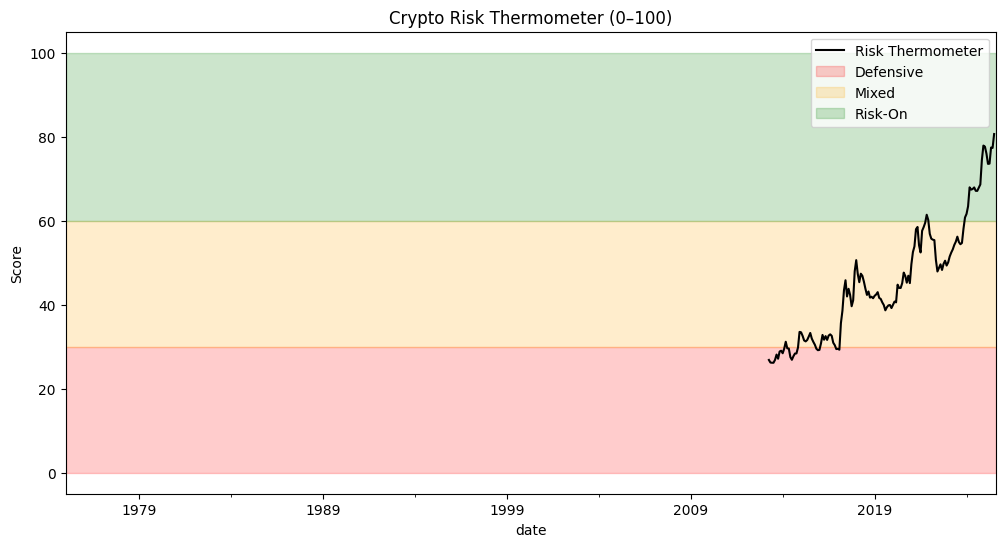

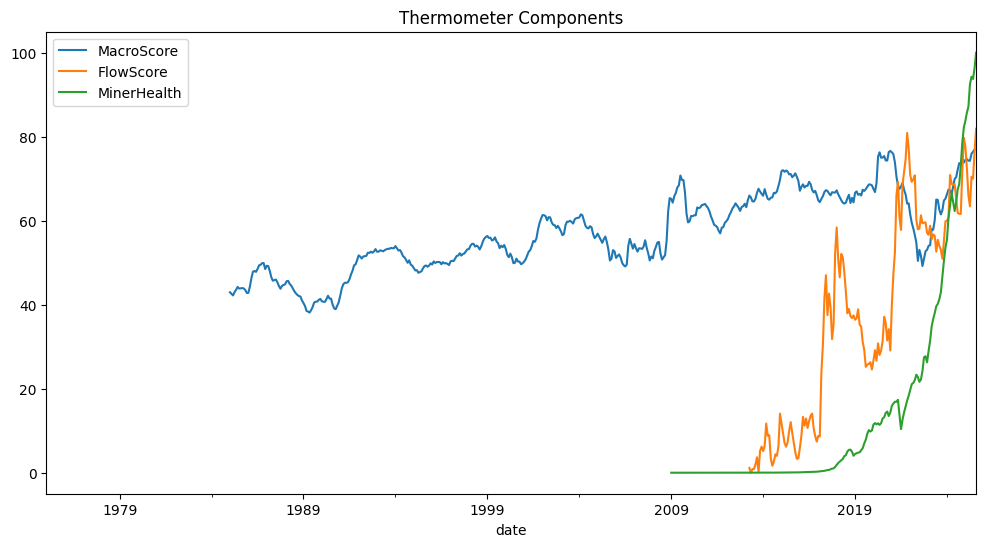

In [6]:
plt.figure(figsize=(12,6))
df_scores["Thermometer"].plot(label="Risk Thermometer", color="black")
plt.axhspan(0,30, color="red", alpha=0.2, label="Defensive")
plt.axhspan(30,60, color="orange", alpha=0.2, label="Mixed")
plt.axhspan(60,100, color="green", alpha=0.2, label="Risk-On")
plt.title("Crypto Risk Thermometer (0–100)")
plt.ylabel("Score")
plt.legend()
plt.show()

# Sub-scores
df_scores[["MacroScore", "FlowScore", "MinerHealth"]].plot(figsize=(12,6))
plt.title("Thermometer Components")
plt.show()


In [7]:
import requests
import pandas as pd
from dotenv import load_dotenv
import os


# --- Setup ---
load_dotenv()
API_KEY = os.getenv("GECKO_KEY") 
headers = {"x-cg-pro-api-key": API_KEY}

# Endpoint for BTC price history
url = "https://pro-api.coingecko.com/api/v3/coins/bitcoin/market_chart"

# Parameters (daily data, 5 years history as example)
params = {
    "vs_currency": "usd",
    "days": "max",    # use "max" for full history, or e.g. "1825" for 5 years
    "interval": "daily"
}

# Request data
res = requests.get(url, headers=headers, params=params)
print("Status:", res.status_code)

data = res.json()

# Extract BTC prices (list of [timestamp, price])
prices = data["prices"]

# Convert to DataFrame
btc_price = pd.DataFrame(prices, columns=["timestamp", "price"])
btc_price["date"] = pd.to_datetime(btc_price["timestamp"], unit="ms")
btc_price.set_index("date", inplace=True)

# Optional: Resample monthly average price
btc_price = btc_price.resample("ME").mean()

print(btc_price.head())


Status: 200
               timestamp       price
date                                
2013-04-30  1.367194e+12  137.520000
2013-05-31  1.368662e+12  119.423968
2013-06-30  1.371332e+12  107.800359
2013-07-31  1.373933e+12   89.982171
2013-08-31  1.376611e+12  113.732581


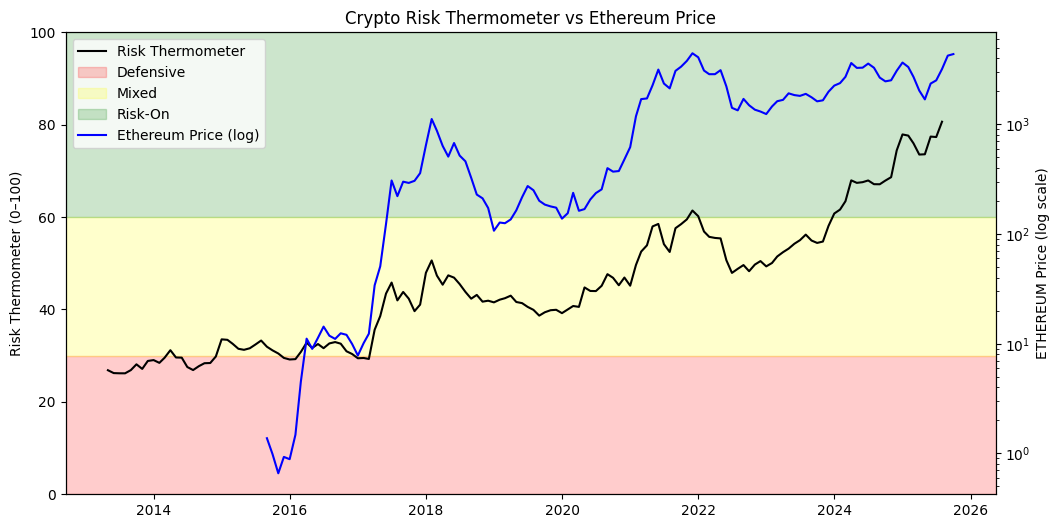

In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# === Function to fetch coin price from CoinGecko ===
def fetch_coin_price(coin_id, currency="usd", days="max", api_key=None):
    url = f"https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    headers = {"accept": "application/json"}
    if api_key:
        headers["x-cg-pro-api-key"] = api_key

    params = {"vs_currency": currency, "days": days}
    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.text}")

    data = response.json()["prices"]
    df = pd.DataFrame(data, columns=["timestamp", "price"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df.set_index("timestamp", inplace=True)
    df = df.resample("ME").mean()  # monthly frequency
    return df

# === Function to plot overlay ===
def plot_thermometer_vs_coin(thermometer, coin_df, coin_name="BTC"):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot thermometer
    ax1.plot(thermometer.index, thermometer.values, color="black", label="Risk Thermometer")
    ax1.set_ylabel("Risk Thermometer (0–100)")
    ax1.set_ylim(0, 100)

    # Background zones
    ax1.axhspan(0, 30, color="red", alpha=0.2, label="Defensive")
    ax1.axhspan(30, 60, color="yellow", alpha=0.2, label="Mixed")
    ax1.axhspan(60, 100, color="green", alpha=0.2, label="Risk-On")

    # Secondary axis for coin price (log scale)
    ax2 = ax1.twinx()
    ax2.plot(coin_df.index, coin_df["price"], color="blue", label=f"{coin_name.capitalize()} Price (log)")
    ax2.set_yscale("log")
    ax2.set_ylabel(f"{coin_name.upper()} Price (log scale)")

    # Title
    plt.title(f"Crypto Risk Thermometer vs {coin_name.capitalize()} Price")

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.show()


# === Main Program ===
if __name__ == "__main__":
    load_dotenv()
    api_key = os.getenv("GECKO_KEY")

    # Ask user for input
    coin_choice = input("Enter the coin you want to fetch (e.g., bitcoin, ethereum, solana): ").strip().lower()

    try:
        coin_df = fetch_coin_price(coin_choice, api_key=api_key)
        # thermometer must be your preloaded pandas Series with datetime index
        plot_thermometer_vs_coin(thermometer, coin_df, coin_name=coin_choice)
    except Exception as e:
        print("Error:", e)


In [ ]:
import streamlit as st
import pandas as pd
import requests
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# === Function to fetch data from CoinGecko ===
def fetch_coin_data(coin_id, metric="prices", days="max", api_key=None):
    url = f"https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    headers = {"accept": "application/json"}
    if api_key:
        headers["x-cg-pro-api-key"] = api_key

    params = {"vs_currency": "usd", "days": days}
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.text}")
    
    data = response.json()[metric]
    df = pd.DataFrame(data, columns=["timestamp", "value"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df.set_index("timestamp", inplace=True)
    return df

# === Streamlit App ===
st.title("📊 Crypto Risk Thermometer Dashboard")

# Sidebar controls
coin_choice = st.sidebar.selectbox("Select Coin", ["bitcoin", "ethereum", "solana", "binancecoin"])
metric_choice = st.sidebar.selectbox("Overlay Metric", ["Price", "Market Cap"])
days_choice = st.sidebar.radio("Time Horizon", ["365", "1825", "max"], index=2)
freq_choice = st.sidebar.radio("Frequency", ["Daily", "Monthly"], index=1)

load_dotenv()
api_key = os.getenv("GECKO_KEY")

# Fetch coin data
metric_map = {"Price": "prices", "Market Cap": "market_caps"}
coin_df = fetch_coin_data(coin_choice, metric=metric_map[metric_choice], days=days_choice, api_key=api_key)

# Resample if monthly
if freq_choice == "Monthly":
    coin_df = coin_df.resample("ME").mean()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(thermometer.index, thermometer.values, color="black", label="Risk Thermometer")
ax1.set_ylim(0, 100)
ax1.axhspan(0, 30, color="red", alpha=0.2)
ax1.axhspan(30, 60, color="yellow", alpha=0.2)
ax1.axhspan(60, 100, color="green", alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(coin_df.index, coin_df["value"], color="blue", label=f"{coin_choice.capitalize()} {metric_choice} (log)")
ax2.set_yscale("log")

plt.title(f"Crypto Risk Thermometer vs {coin_choice.capitalize()} {metric_choice}")
st.pyplot(fig)
